I have previously shown a [python implementation](https://github.com/bicv/SparseEdges) which allows for the extraction a sparse set of edges from an image. We were using the raw luminance as the input to the algorithm. What happens if you use [gamma correction](https://en.wikipedia.org/wiki/Gamma_correction)? 

![frida on gamma](../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit/gamma.png)

* this is exposed in the following book chapter (see also https://laurentperrinet.github.io/publication/perrinet-15-bicv ):

```bibtex
@inbook{Perrinet15bicv,
    title = {Sparse models},
    author = {Perrinet, Laurent U.},
    booktitle = {Biologically-inspired Computer Vision},
    chapter = {13},
    editor = {Keil, Matthias and Crist\'{o}bal, Gabriel and Perrinet, Laurent U.},
    publisher = {Wiley, New-York},
    year = {2015}
}
```
    
* Results : for this particular image, we checked that using the luminance ($\gamma \approx 1$) is the correct choice. This may not be the case for other types of images which would justify an image-by-image local gain control.
    
<!-- TEASER_END -->


# setting up the sparse coding framework

In [1]:
import numpy as np
from SparseEdges import SparseEdges
mp = SparseEdges('https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py')
if not mp.pe.do_whitening: print('\!/ Wrong parameters... \!/')
    
# where should we store the data + figures generated by this notebook
import os
mp.pe.do_mask = True
# mp.pe.use_cache = False

mp.pe.N_X, mp.pe.N_Y = 256, 256

mp.pe.N = 1024
#mp.pe.N = 2048
#mp.pe.N = 64
# name = f'/tmp/2019-11-13-B_progressive'
mp.pe.matpath, mp.pe.figpath = '../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit', '../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit'
mp.pe.MP_alpha = 1.
mp.pe.MP_alpha = .8

mp.pe.mask_exponent = 6.
mp = SparseEdges(mp.pe)
mp.init()
print('mp.pe.N_X, mp.pe.N_Y', mp.pe.N_X, mp.pe.N_Y)
# defining input image (get it @ https://www.flickr.com/photos/doug88888/6370387703)
# https://images2.minutemediacdn.com/image/upload/c_crop,h_1286,w_2288,x_0,y_12/v1553818270/shape/mentalfloss/70991-istock-638419754.jpg

print('Default parameters: ', mp.pe)

mp.pe.N_X, mp.pe.N_Y 256 256
Default parameters:  {'verbose': 0, 'N_image': None, 'seed': 42, 'N_X': 256, 'N_Y': 256, 'noise': 0.33, 'do_mask': True, 'mask_exponent': 6.0, 'do_whitening': True, 'white_name_database': 'kodakdb', 'white_n_learning': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4, 'white_steepness': 4.0, 'white_recompute': False, 'base_levels': 1.618, 'n_theta': 24, 'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N': 1024, 'MP_alpha': 0.8, 'd_width': 45.0, 'd_min': 0.1, 'd_max': 2.0, 'N_r': 6, 'N_Dtheta': 24, 'N_phi': 12, 'N_scale': 5, 'loglevel_max': 7.0, 'edge_mask': False, 'do_rank': False, 'scale_invariant': True, 'multiscale': False, 'kappa_phase': 0.0, 'weight_by_distance': True, 'svm_n_jobs': 1, 'svm_test_size': 0.2, 'N_svm_grid': 32, 'N_svm_cv': 50, 'C_range_begin': -5, 'C_range_end': 10.0, 'gamma_range_begin': -14, 'gamma_range_end': 3, 'svm_KL_m': 0.34, 'svm_tol': 0.001, 'svm_max_iter': -1, 'svm_log': False, 'svm_norm': False, 'figpath'

The useful imports for a nice notebook:

In [2]:
import matplotlib
fontsize = 15
matplotlib.rcParams['figure.max_open_warning'] = 400
matplotlib.rcParams.update({'text.usetex': False,
                            'axes.labelsize':19,
                            'xtick.labelsize':fontsize,
                            'ytick.labelsize':fontsize,
                            'legend.fontsize':fontsize,
                           })
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)

fig_width = 14

In [3]:
print('Range of spatial frequencies: ', mp.sf_0)

Range of spatial frequencies:  [0.4545 0.2935 0.1895 0.1224 0.079  0.051  0.0329 0.0213 0.0137 0.0089
 0.0057]


In [4]:
print('Range of angles (in degrees): ', mp.theta*180./np.pi)

Range of angles (in degrees):  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]


## coding one image with different gammas

In [5]:
from SLIP import imread
SHOW = True

In [6]:
def normalize(image, do_full=True, verbose=SHOW):
    if do_full: # normalizes in the full range between 0 and 1
        if verbose: print('in norm', image.mean(), image.min(), image.max())
        image -= image.min()
        if verbose: print('decenter', image.mean(), image.min(), image.max())
        image /= image.max()
        if verbose: print('max out', image.mean(), image.min(), image.max())
    else:# normalizes such that the mean is .5 and the extremum is 0 or 1
        if verbose: print('in norm', image.mean(), image.min(), image.max())
        image -= image.mean()
        if verbose: print('decenter', image.mean(), image.min(), image.max())
        image /= np.abs(image).max()
        if verbose: print('max out', image.mean(), image.min(), image.max())
        image *= .5
        if verbose: print('max out', image.mean(), image.min(), image.max())
        image += .5
        if verbose: print('recenter', image.mean(), image.min(), image.max())
    return image

def preprocess(image, gamma=1, verbose=SHOW):
    if verbose: print('preproc', image.mean(), image.min(), image.max())
    image = normalize(image, do_full=True)
    if verbose: print('norm', image.mean(), image.min(), image.max())
    image = image**gamma
    if verbose: print('out', image.mean(), image.min(), image.max())
    return image

def deprocess(white, gamma=1, verbose=SHOW):
    
    image = mp.dewhitening(white)
    if image.max() > image.min(): image = normalize(image, do_full=True)
    image = image**(1/gamma)
    if image.max() > image.min(): image = normalize(image, do_full=True)
    
    return image

In [7]:
from SLIP import imread
url = 'https://upload.wikimedia.org/wikipedia/commons/d/d7/Meisje_met_de_parel.jpg'
url = 'https://farm7.staticflickr.com/6058/6370387703_5e718ea681_q_d.jpg'
url = 'https://upload.wikimedia.org/wikipedia/en/1/1e/Frida_Kahlo_%28self_portrait%29.jpg'
url = 'http://1.bp.blogspot.com/-EIqqVOCuIcE/T5HfIXEk05I/AAAAAAAAARk/NzQrgFJ5itI/s1600/einstein.jpg'
image = imread(url)
print('image shape=', image.shape)

image shape= (500, 500)


In [8]:
# TODO make it square

In [9]:
#image = mp.imread(os.path.join(mp.pe.matpath, '6370387703_5e718ea681_q_d.jpg'))
from skimage.transform import resize
image = resize(image, (mp.pe.N_X, mp.pe.N_Y))
print('image shape=', mp.pe.N_X, mp.pe.N_Y, image.shape)
if SHOW: print('in', image.mean(), image.min(), image.max())
image = mp.preprocess(image)
if SHOW: print('before process', image.mean(), image.min(), image.max())
image = preprocess(image, gamma=1.)
if SHOW: print('before mask', image.mean(), image.min(), image.max())
#if mp.pe.do_mask: image = (image-image.mean())*mp.mask + image.mean()
if mp.pe.do_mask: 
    im_med = np.median(image)
    image = (image-im_med)*mp.mask + im_med
if SHOW: print('after mask', image.mean(), image.min(), image.max())
image_original = image.copy()    

image shape= 256 256 (256, 256)
in 0.3079660564791832 5.864053365488982e-07 0.9932001735409042
before process 4.036569908189014e-08 -0.3711893295814118 0.680914061819952
preproc 4.036569908189014e-08 -0.3711893295814118 0.680914061819952
in norm 4.036569908189014e-08 -0.3711893295814118 0.680914061819952
decenter 0.3711893699471109 0.0 1.0521033914013638
max out 0.352806932266134 0.0 1.0
norm 0.352806932266134 0.0 1.0
out 0.352806932266134 0.0 1.0
before mask 0.352806932266134 0.0 1.0
after mask 0.3646051922340162 0.0010278417099531256 0.943463368763109


In [10]:
gammas = np.linspace(.5, 1.5, 7)
print('gammas =', gammas)

gammas = [0.5    0.6667 0.8333 1.     1.1667 1.3333 1.5   ]


in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 

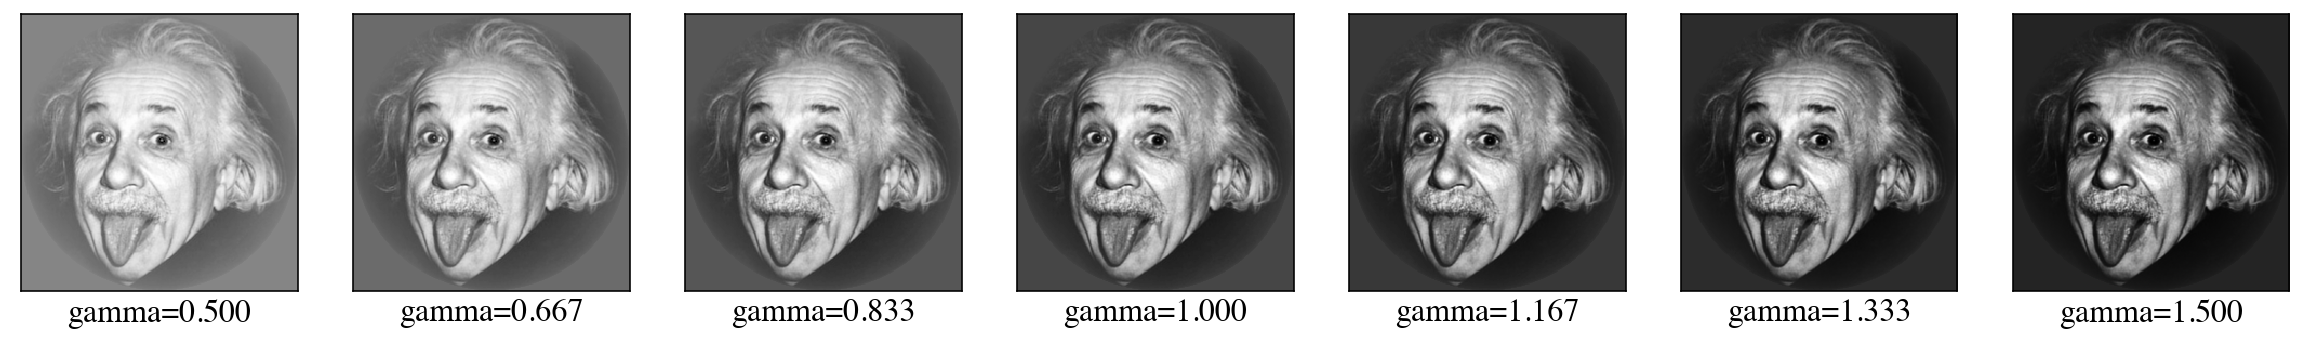

In [11]:
fig, axs = plt.subplots(1, len(gammas), figsize=(21, 5))
for gamma, ax in zip(gammas, axs):
    image = image_original.copy()
    image = preprocess(image, gamma=gamma, verbose=False)
    ax.imshow(image, vmin=0, vmax=1, cmap=plt.gray())
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f'gamma={gamma:.3f}', fontsize=16)
import os
fig.savefig(os.path.join(mp.pe.figpath, 'gamma.png'), dpi=600, bbox_inches='tight', pad_inches=0)

in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 

Text(0, 0.5, 'intensity')

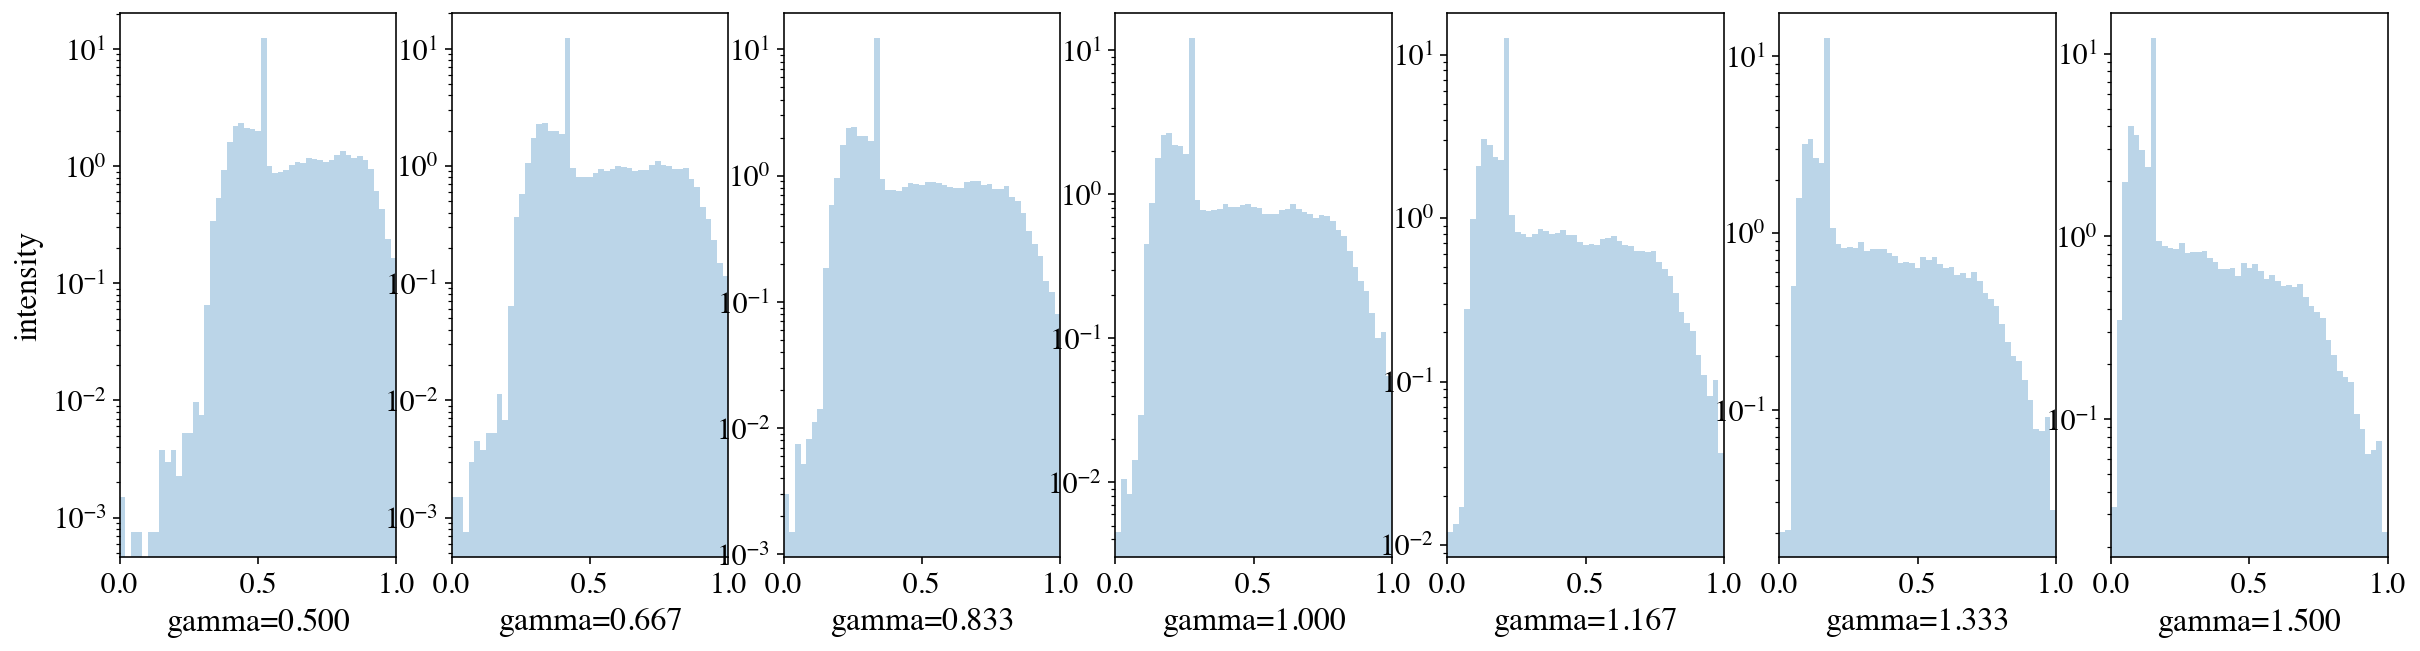

In [12]:
fig, axs = plt.subplots(1, len(gammas), figsize=(21, 5))
for gamma, ax in zip(gammas, axs):
    image = image_original.copy()
    image = preprocess(image, gamma=gamma, verbose=False)
    ax.hist(image.ravel(), bins=np.linspace(0, 1, 50), alpha=.3, label=gamma, density=True)
    
    ax.set_xlim([0, 1])
    #ax.set_xlabel('gammas')
    ax.set_xlabel(f'gamma={gamma:.3f}', fontsize=16)
    ax.set_yscale('log')
axs[0].set_ylabel('intensity', fontsize=16)   
#_ = plt.legend()

Processing one image with different values of gamma:

In [13]:
for gamma in gammas:
    name = f'MP_gamma_{gamma}'
    print('processing ', name)
    matname = os.path.join(mp.pe.matpath, name + '.npy')
    image = image_original.copy()
    image = preprocess(image, gamma=gamma)

    white = mp.whitening(image)
    
    try:
        edges = np.load(matname)
    except:
        edges, C_res = mp.run_mp(white, verbose=True)
        np.save(matname, edges)    

    i_Ns = np.arange(0, mp.pe.N, 16)
    matname_MSE = os.path.join(mp.pe.matpath, name + '_MSE.npy')
    matname_SSIM = os.path.join(mp.pe.matpath, name + '_SSIM.npy')
    try:
        MSE = np.load(matname_MSE)
        SSIM = np.load(matname_SSIM)
    except:
        image_original_crop = image_original[mp.pe.N_X//4:(mp.pe.N_X*3)//4, mp.pe.N_Y//4:(mp.pe.N_Y*3)//4]        
        MSE = np.zeros(len(i_Ns))
        # https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html
        from skimage.metrics import structural_similarity as ssim
        opts_ssim = dict(multichannel=False, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
        SSIM = np.zeros(len(i_Ns))
        for ii_N, i_N in enumerate(i_Ns):
            white_rec = mp.reconstruct(edges[:, :i_N])
            MSE[ii_N] =  ((white-white_rec)**2).mean()
            image_rec = deprocess(white_rec, gamma=gamma)
            image_rec_crop = image_rec[mp.pe.N_X//4:(mp.pe.N_X*3)//4, mp.pe.N_Y//4:(mp.pe.N_Y*3)//4]
            SSIM[ii_N] =  ssim(image_original_crop, image_rec_crop, 
                              data_range=image_rec_crop.max() - image_rec_crop.min())   
        np.save(matname_MSE, MSE)        
        np.save(matname_SSIM, SSIM)         

processing  MP_gamma_0.5
preproc 0.3646051922340162 0.0010278417099531256 0.943463368763109
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
norm 0.3857848522125549 0.0 1.0
out 0.5999859221040427 0.0 1.0
processing  MP_gamma_0.6666666666666666
preproc 0.3646051922340162 0.0010278417099531256 0.943463368763109
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
norm 0.3857848522125549 0.0 1.0
out 0.5139223026658271 0.0 1.0
processing  MP_gamma_0.8333333333333333
preproc 0.3646051922340162 0.0010278417099531256 0.943463368763109
in norm 0.3646051922340162 0.0010278417099531256 0.943463368763109
decenter 0.36357735052406304 0.0 0.9424355270531559
max out 0.3857848522125549 0.0 1.0
norm 0.3857848522125549 0.0 1.0
out 0.44359218358910735 0.0 1.0
processing  MP_gamma_1.0
preproc 0.3646051

In [14]:
gamma = 1.
name = f'MP_gamma_{gamma}'
matname = os.path.join(mp.pe.matpath, name + '.npy')
edges = np.load(matname)

in norm 0.00022461749341232302 -0.4647099710904494 0.4574831970958212
decenter 0.46493458858386183 0.0 0.9221931681862706
max out 0.50416182273208 0.0 1.0
in norm 0.50416182273208 0.0 1.0
decenter 0.50416182273208 0.0 1.0
max out 0.50416182273208 0.0 1.0


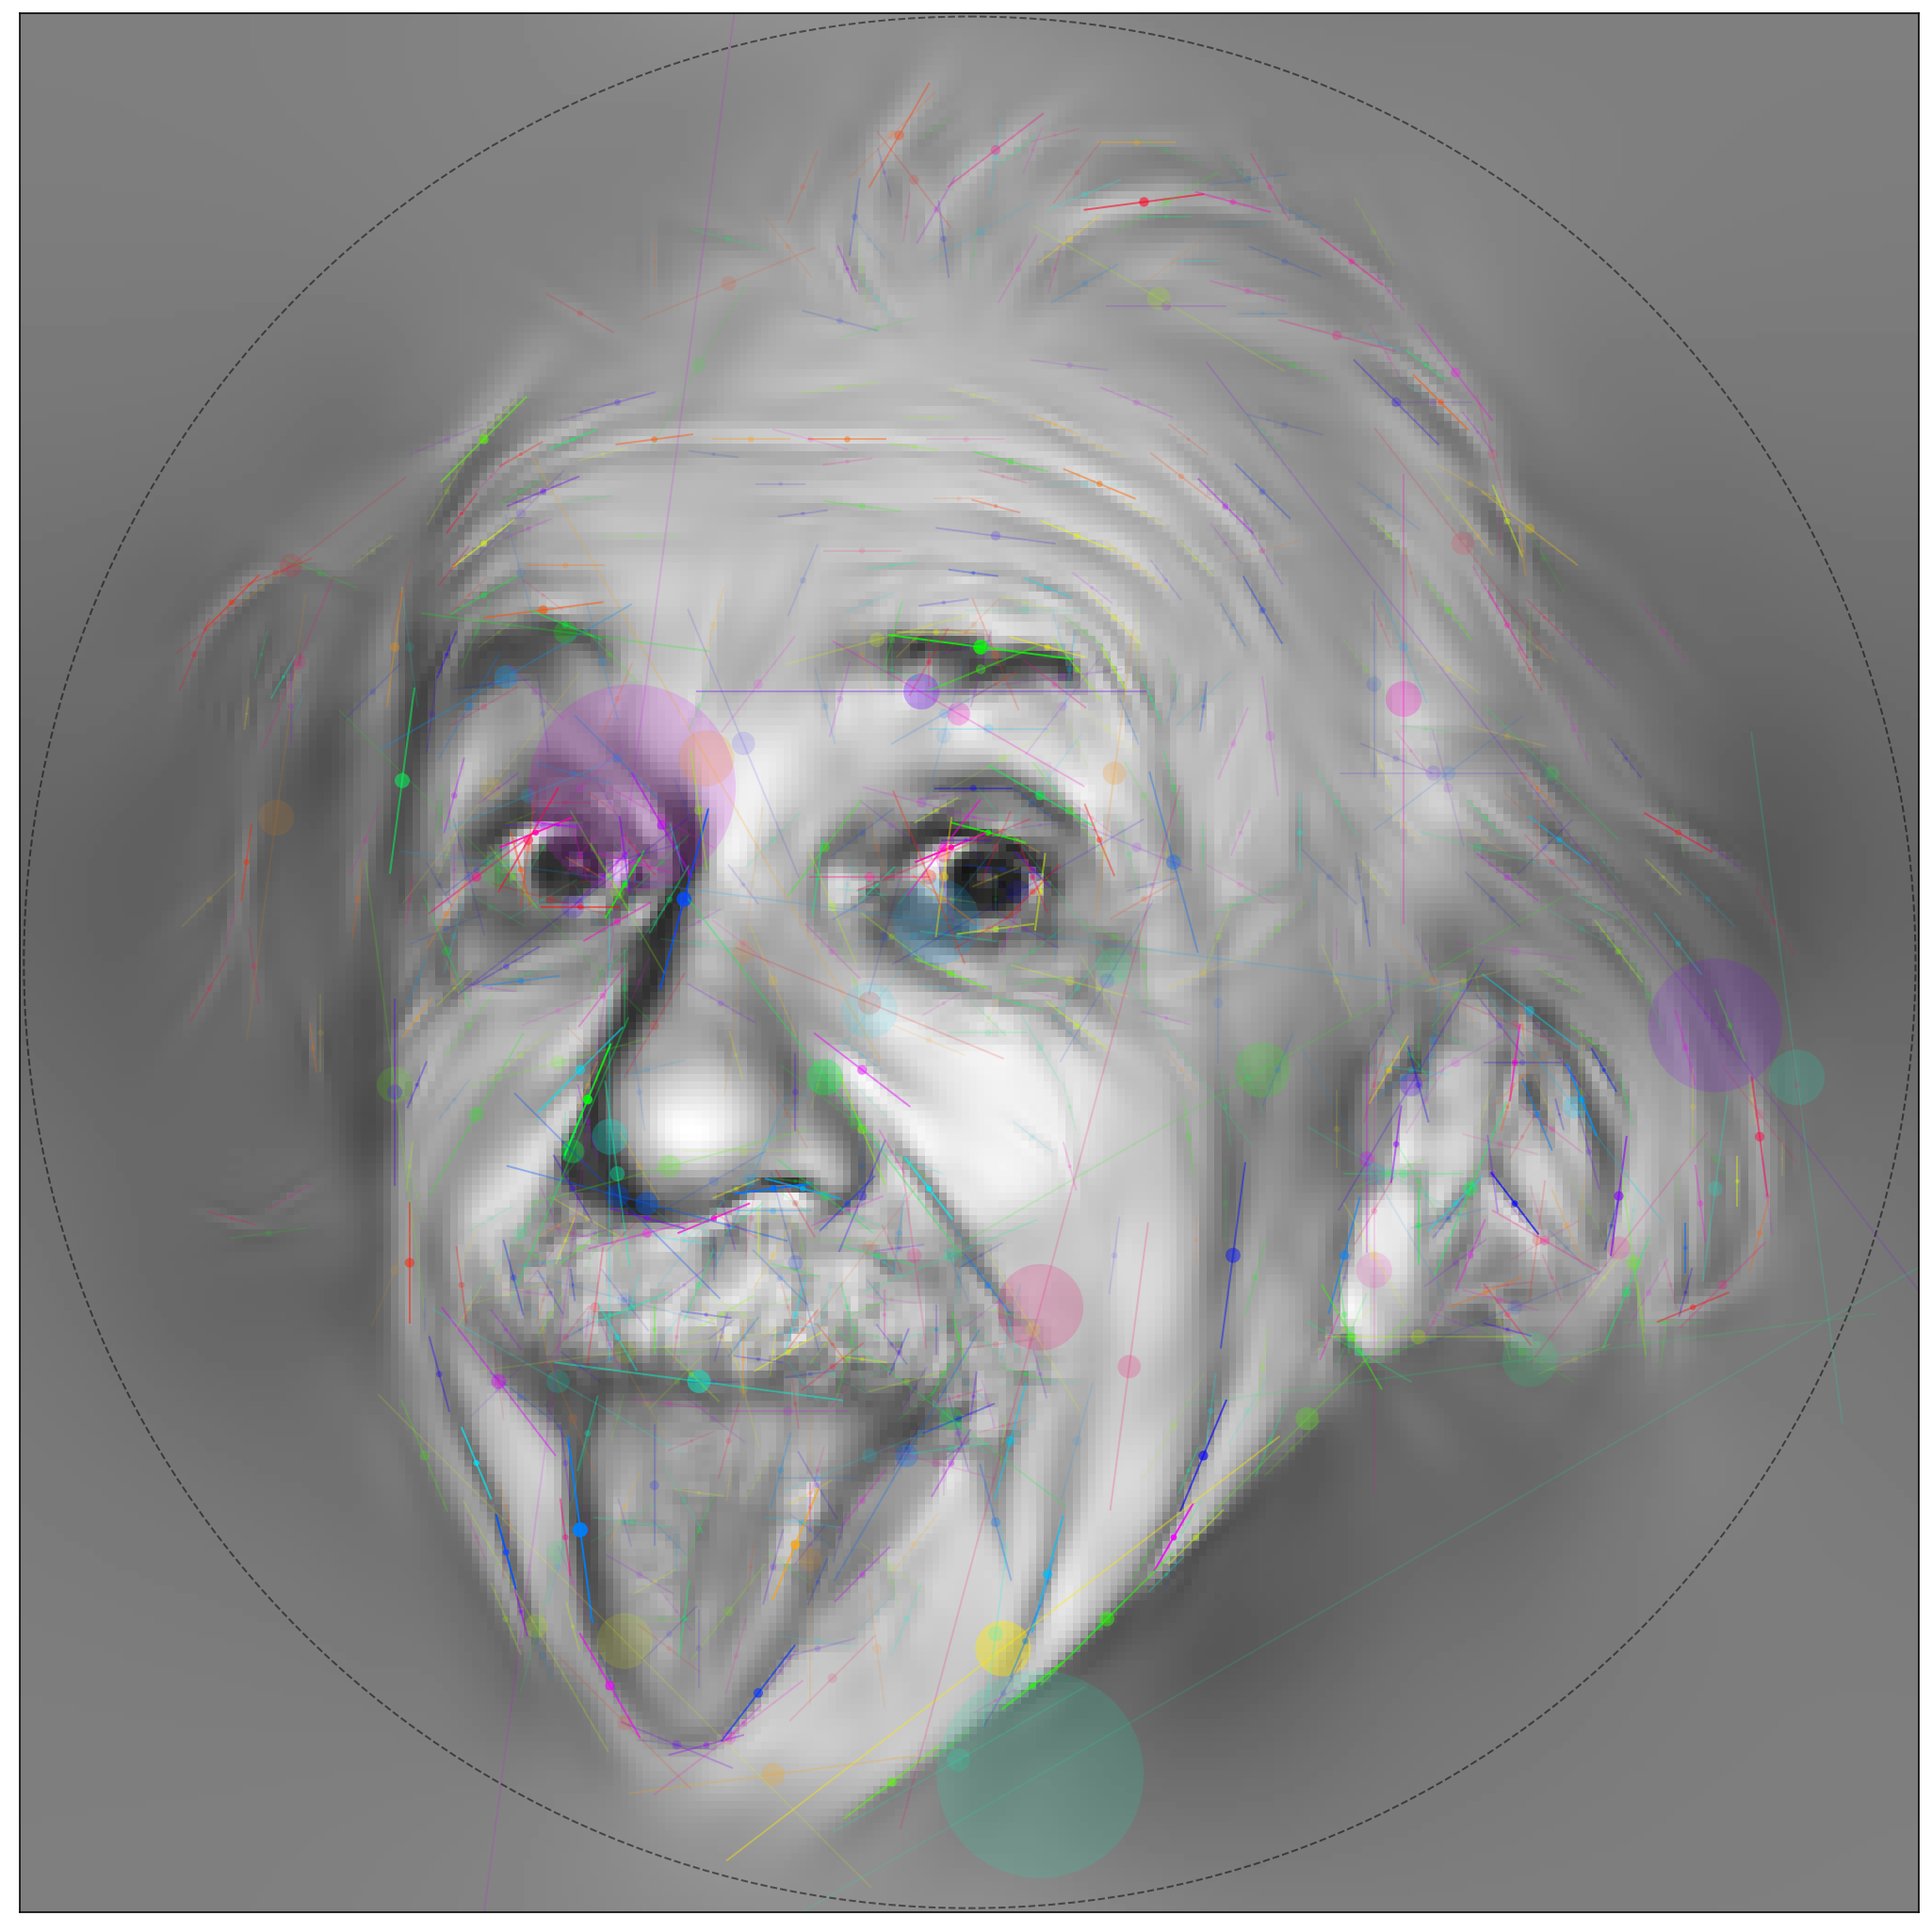

In [15]:
white_rec = mp.reconstruct(edges)
image_rec = deprocess(white_rec, gamma=gamma)

fig_width_pt = 318.670  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches
mp.pe.figsize_edges = .382 * fig_width  # useful for papers
mp.pe.figsize_edges = 9 # useful in notebooks
mp.pe.line_width = 1.
mp.pe.scale = 1.
fig, a = mp.show_edges(edges, image=2*image_rec-1, show_phase=True, show_mask=True)
#mp.savefig(fig, name + '_rec')

A nice property of Matching Pursuit is that one can reconstruct the image from the edges:

In [16]:
white_rec = mp.reconstruct(edges)
print('remaining energy  = ', ((white-white_rec)**2).sum()/(white**2).sum()*100, '%')

remaining energy  =  22.368278352416795 %


The whitened reconstructed image looks like:

in norm 0.00022461749341232302 -0.4647099710904494 0.4574831970958212
decenter 0.46493458858386183 0.0 0.9221931681862706
max out 0.50416182273208 0.0 1.0
in norm 0.50416182273208 0.0 1.0
decenter 0.50416182273208 0.0 1.0
max out 0.50416182273208 0.0 1.0


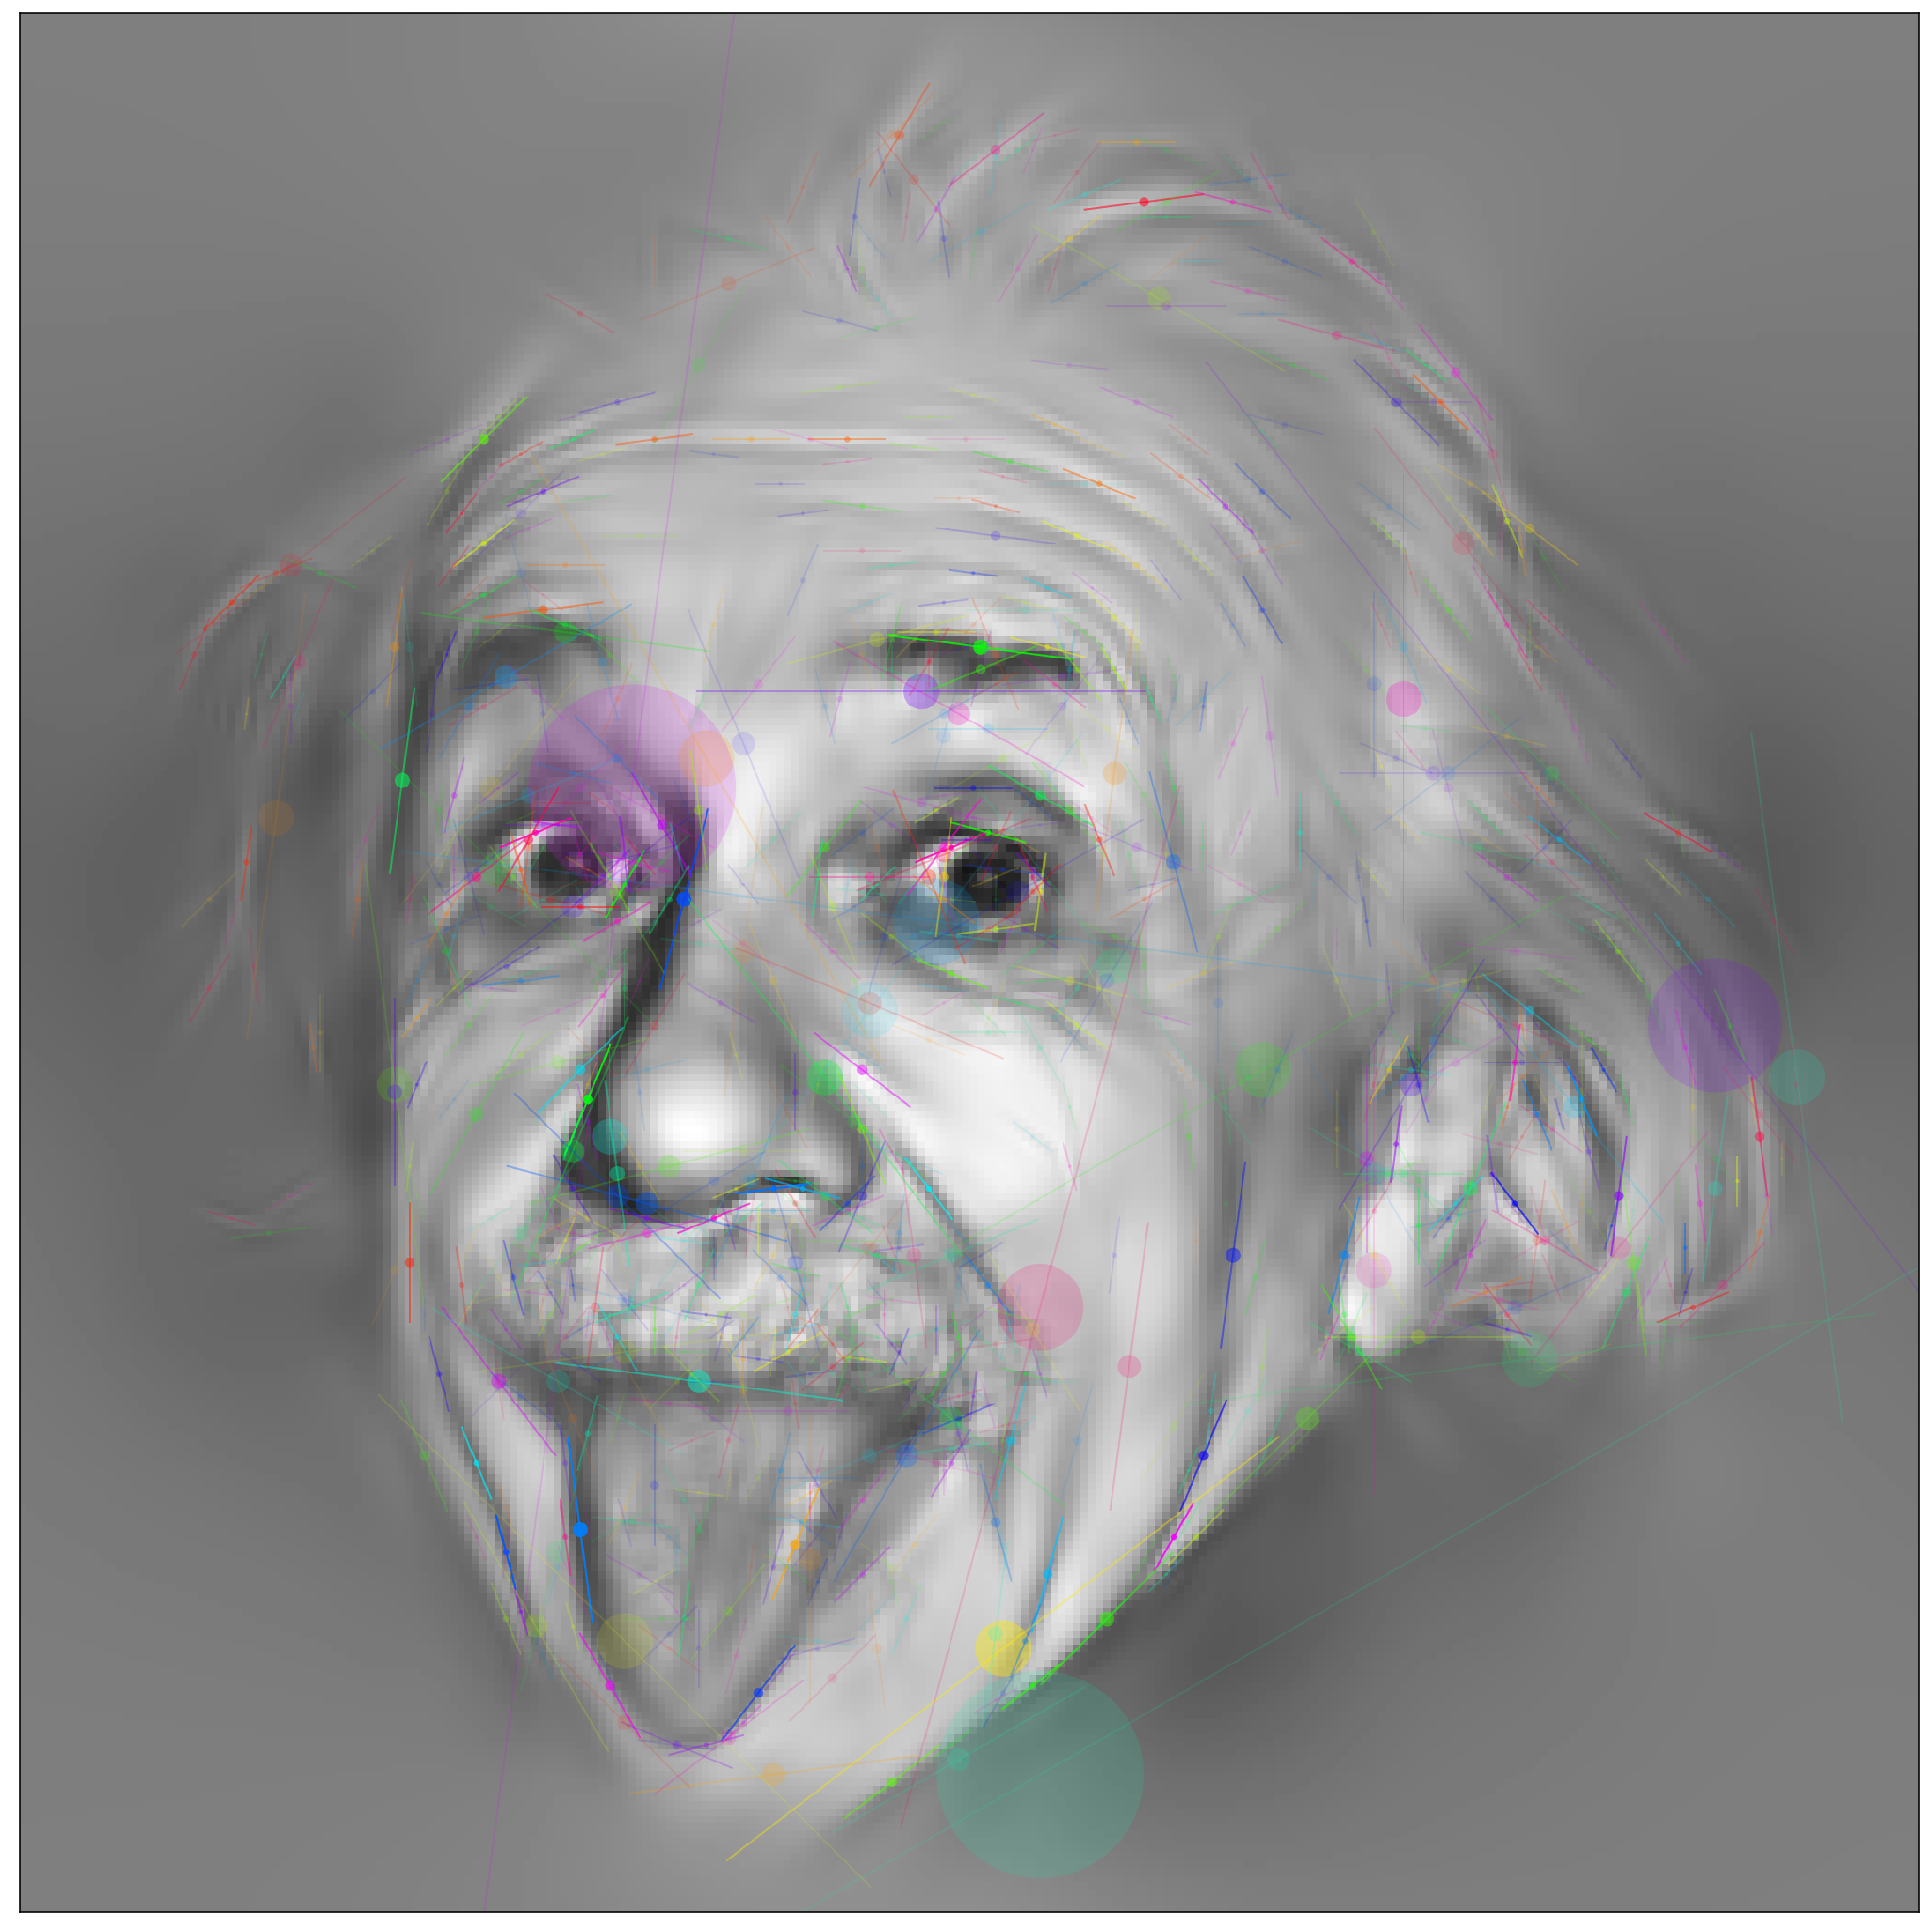

In [17]:
image_rec = deprocess(white_rec, gamma=gamma)
fig, a = mp.show_edges(edges, image=image_rec);

let's check how this varies with gamma:

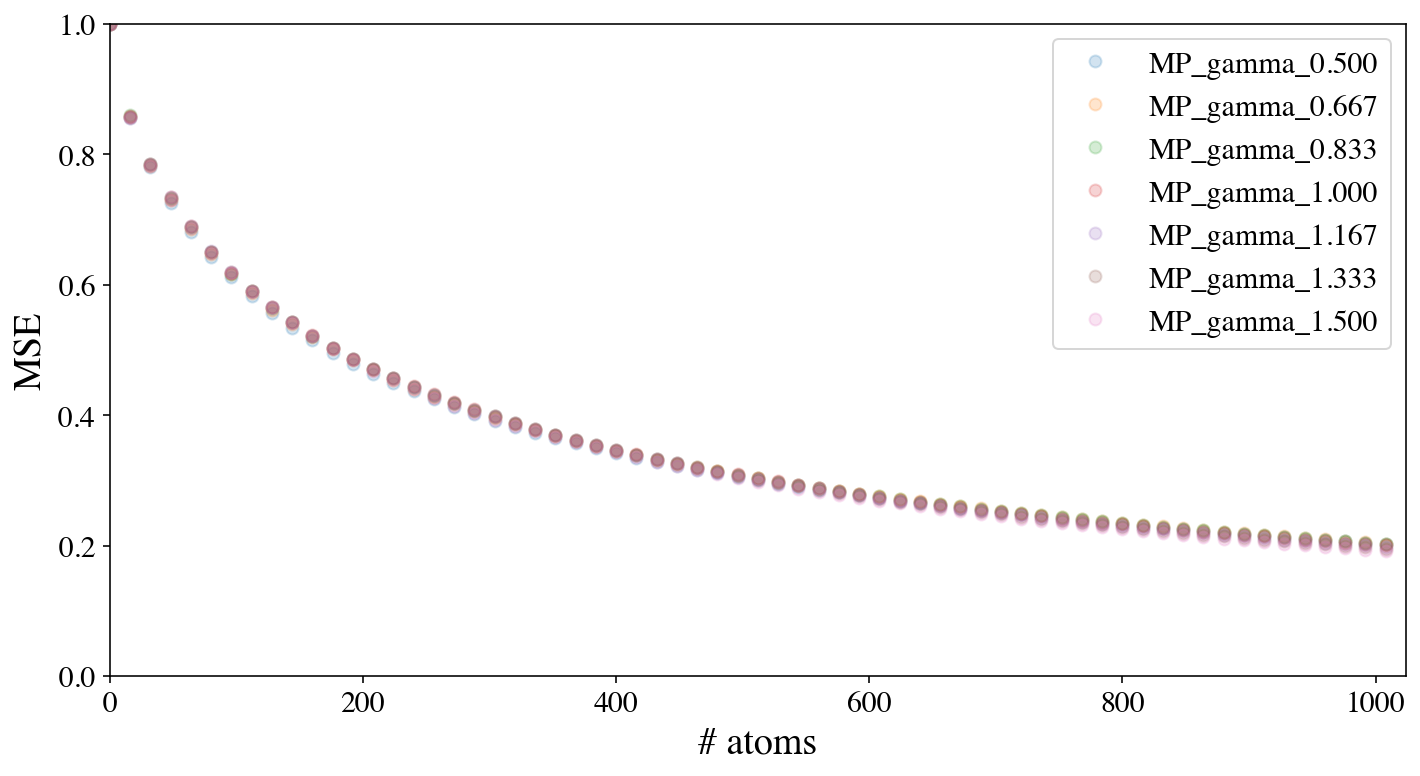

In [18]:
MSE_0 = (white**2).sum()

plt.figure(figsize=(12,6))
plt.subplot(111)
for gamma in gammas:
    name = f'MP_gamma_{gamma}'
    matname_MSE = os.path.join(mp.pe.matpath, name + '_MSE.npy')
    MSE = np.load(matname_MSE)
    plt.plot(i_Ns, MSE/MSE[0], 'o', label=f'MP_gamma_{gamma:.3f}', alpha=.2)
plt.xlim([0, mp.pe.N])
plt.ylim([0, 1])
plt.xlabel('# atoms')
plt.ylabel('MSE')
_ = plt.legend()

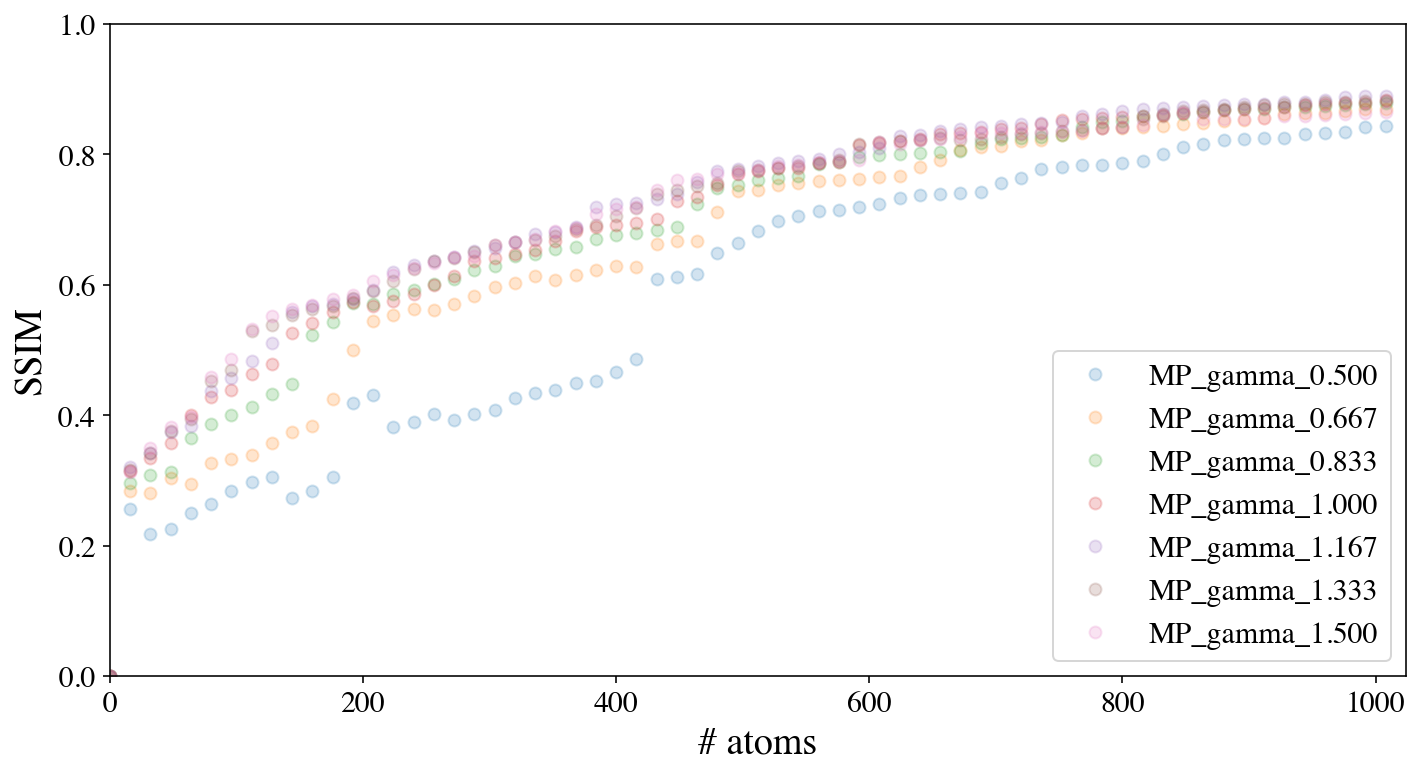

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(111)
for gamma in gammas:
    name = f'MP_gamma_{gamma}'
    matname_SSIM = os.path.join(mp.pe.matpath, name + '_SSIM.npy')
    SSIM = np.load(matname_SSIM)    
    plt.plot(i_Ns, SSIM, 'o', label=f'MP_gamma_{gamma:.3f}', alpha=.2)
plt.xlim([0, mp.pe.N])
plt.ylim([0, 1])
plt.xlabel('# atoms')
plt.ylabel('SSIM')
_ = plt.legend()

Text(0, 0.5, 'SSIM')

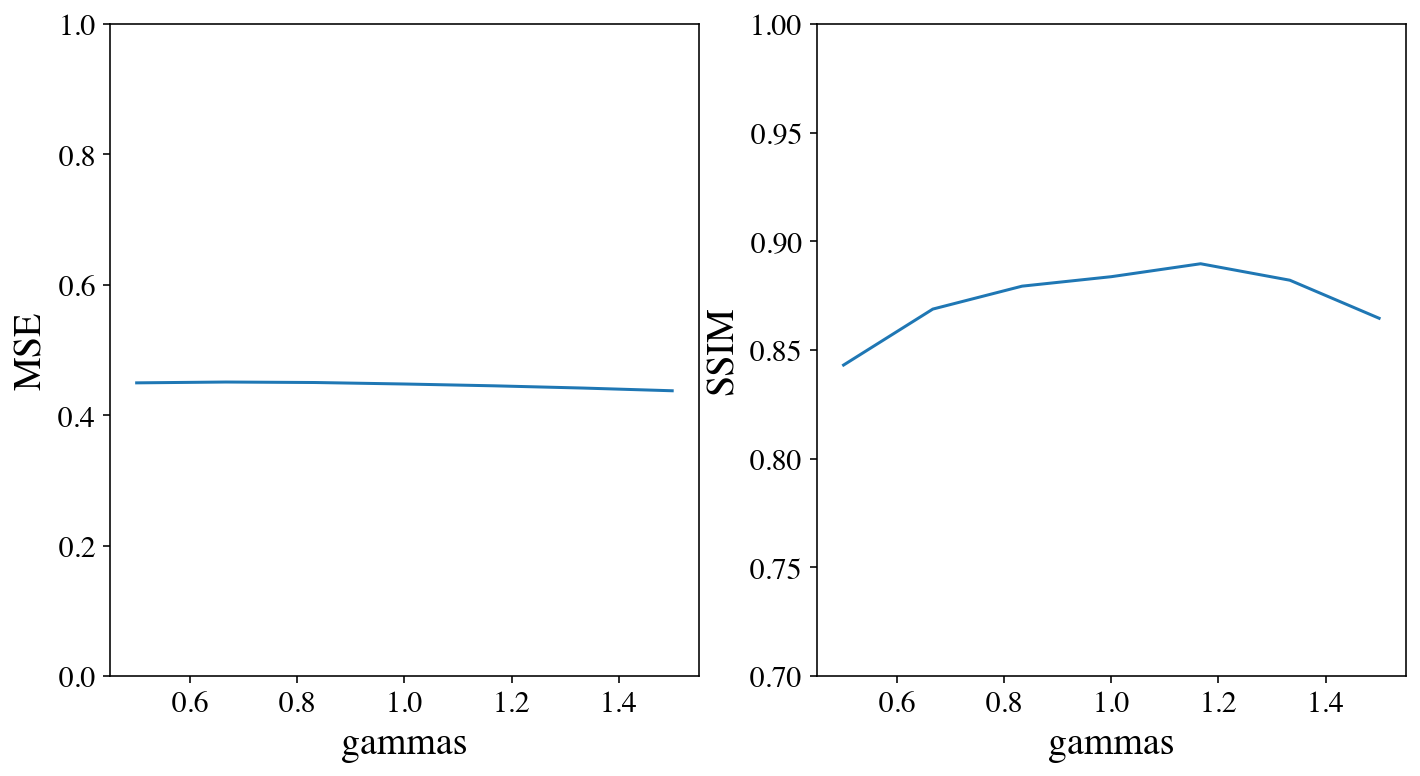

In [20]:
MSE_0 = (white**2).sum()

fig, axs = plt.subplots(1, 2, figsize=(12,6))
MSEs, SSIMs = [], []
for gamma in gammas:
    name = f'MP_gamma_{gamma}'
    matname_MSE = os.path.join(mp.pe.matpath, name + '_MSE.npy')
    MSE = np.load(matname_MSE)
    MSEs.append(MSE[-1]/MSE[0])
    matname_SSIM = os.path.join(mp.pe.matpath, name + '_SSIM.npy')
    SSIM = np.load(matname_SSIM)    
    SSIMs.append(SSIM[-1]) 

axs[0].plot(gammas, np.sqrt(MSEs))
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('gammas')
axs[0].set_ylabel('MSE')
axs[1].plot(gammas, SSIMs)
axs[1].set_ylim([0.7, 1])
axs[1].set_xlabel('gammas')
axs[1].set_ylabel('SSIM')

## some book keeping for the notebook

In [21]:
%ls -l ../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit/
#%rm ../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit/MP_gamma*
#%rm ../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit/MP_gamma*MSE*
#%rm ../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit/MP_gamma*SSIM*
#%rm ../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit/MP_gamma*npy

total 3552
-rw-r--r--  1 laurentperrinet  staff   10602 Jun 26  2018 6370387703_5e718ea681_q_d.jpg
-rw-r--r--  1 laurentperrinet  staff   49280 Dec  6 12:18 MP_gamma_0.5.npy
-rw-r--r--  1 laurentperrinet  staff     640 Dec  6 12:21 MP_gamma_0.5_MSE.npy
-rw-r--r--  1 laurentperrinet  staff     640 Dec  6 12:21 MP_gamma_0.5_SSIM.npy
-rw-r--r--  1 laurentperrinet  staff   49280 Dec  6 12:50 MP_gamma_0.6666666666666666.npy
-rw-r--r--  1 laurentperrinet  staff     640 Dec  6 12:53 MP_gamma_0.6666666666666666_MSE.npy
-rw-r--r--  1 laurentperrinet  staff     640 Dec  6 12:53 MP_gamma_0.6666666666666666_SSIM.npy
-rw-r--r--  1 laurentperrinet  staff   49280 Dec  6 13:22 MP_gamma_0.8333333333333333.npy
-rw-r--r--  1 laurentperrinet  staff     640 Dec  6 13:24 MP_gamma_0.8333333333333333_MSE.npy
-rw-r--r--  1 laurentperrinet  staff     640 Dec  6 13:24 MP_gamma_0.8333333333333333_SSIM.npy
-rw-r--r--  1 laurentperrinet  staff   49280 Dec  6 13:52 MP_gamma_1.0.npy
-rw-r--r--  1 laurentperrinet  sta

In [22]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,SLIP,LogGabor,SparseEdges,matplotlib  -r -g -b

2019-12-10T17:02:55+01:00

CPython 3.7.5
IPython 7.10.1

numpy 1.17.4
SLIP 20191113
LogGabor 20191113
SparseEdges 20191118
matplotlib 3.1.2

compiler   : Clang 11.0.0 (clang-1100.0.33.8)
system     : Darwin
release    : 19.0.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit
host name  : fortytwo
Git hash   : cdffd323fbe042fd38e38609fb7f8dc93c3c116b
Git repo   : https://github.com/laurentperrinet/sciblog.git
Git branch : master
